# Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [2]:
def download_file(url, file_path):
    import requests
    r = requests.get(url)
    with open(file_path, 'wb') as f:
        f.write(r.content)

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

dataset = 'shakespeare.txt' # Other options are mark_twain.txt, charles_dickens.txt

uri = 'https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/'
print(f'Fixed Download URL: {uri+dataset}')
download_file(f'{uri+dataset}', dataset)

# Load chosen dataset. NOTE: If Colab is running out of memory, change the `fraction` parameter to a value between 0 and 1 to load less data.
text = load_dataset(dataset, fraction=0.05)

Fixed Download URL: https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/shakespeare.txt


# 1. Data Preparation (Complete or Incomplete)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
print(f'First 1000 chars: \n\n{text[:1000]}')


First 1000 chars: 

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this electronic versio

In [4]:
print(f'dataset size: {len(text)} characters')

dataset size: 467943 characters


In [5]:
print(f'number of unique characters: {len(set(text))}') # this is case sensitive ;)
unique_words = len(set(text.split()))
print(f'number of unique words: {unique_words}') # well and what about words?

number of unique characters: 105
number of unique words: 18030


## 1.2 Text Pre-Processing

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [6]:
text = text.lower() # convert text to lowercase
print(f'Validation of first 200 chars: \n\n{text[:200]}')

Validation of first 200 chars: 

the project gutenberg ebook of hamlet, by william shakespeare

this ebook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  you may copy it, give it away or
re-


In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

# taking into account that there are ~28000 unique words in the dataset
#  I want to test if around 40% of them will make it as a good threshold
VOCAB_SIZE = int(unique_words * 0.4)
OOV_TOKEN = 'UNK'

tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text])

# Take a look a the word index
word_index = tokenizer.word_index

print(f'VOCAB_SIZE {VOCAB_SIZE}')
print(f"Unique tokens: {len(word_index)}")


VOCAB_SIZE 7212
Unique tokens: 8820


If everything worked, the following line should show you the first 10 words in the vocabulary:

In [8]:
try:
    print(list(tokenizer.word_index.items())[:10])
except AttributeError:
    print("Tokenizer has not been initialized. Possible issue: Complete the relevant section of the assignment to initialize it."
)

[('UNK', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('i', 7), ('in', 8), ('you', 9), ('my', 10)]


## 1.3 Sequence Generation

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [9]:
import numpy as np

# since the average lenght is from 10 to 20 words for general purpose writing I'll be using 20ß
SEQ_LENGTH = 20 # Choose an appropriate sequence length

# Convert the text to a list of sequences of numbers
sequences = tokenizer.texts_to_sequences([text])[0]

# Generate the training sequences
X = []
y = []

for i in range(len(sequences) - SEQ_LENGTH):
    X.append(sequences[i:i+SEQ_LENGTH])
    y.append(sequences[i+SEQ_LENGTH])

# Convert lists to NumPy arrays
# X = np.array(X)
# y = np.array(y)

In [10]:
len(sequences)

77301

Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [11]:
if len(X) > 0 and len(y) > 0:
    print(f'Sequence: {X[0]}\nTarget: {y[0]}')
    print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')
else:
    print("Training sequences have not been generated. Possible issue: Complete the relevant section of the assignment to initialize it.")


Sequence: [2, 58, 56, 374, 4, 93, 30, 588, 223, 15, 374, 12, 18, 2, 165, 4, 715, 1374, 40, 41]
Target: 1075
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no'] -> cost


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [12]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Ensure that tokenizer has been initialized
if tokenizer is not None:
    # Convert X and y to numpy arrays
    X = np.array(X)
    y = np.array(y)

    # One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
    if OOV_TOKEN in tokenizer.word_index:
        mask = y != tokenizer.word_index[OOV_TOKEN]
        X = X[mask]
        y = y[mask]

    # One-hot encode the target token
    y = to_categorical(y, num_classes=VOCAB_SIZE)

    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
else:
    print("Tokenizer has not been initialized. Please initialize it and load the vocabulary before continuing.")


X_train shape: (60537, 20)
y_train shape: (60537, 7212)


# 2. Model Development (Complete or Incomplete)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [13]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

EMBEDDING_DIM=50

model = Sequential([
    # Embedding layer: input_dim is the vocabulary size,
    # output_dim is the embedding size
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM),

    # Recurrent layer: LSTM.
    # units represent the number of neuron layers
    LSTM(units=192, return_sequences=False),

    # Dense layer: output size is the vocabulary size for predicting the next token.
    Dense(VOCAB_SIZE, activation='softmax')
])

# Check if the model has layers before trying to print the summary
if len(model.layers) > 0:
    model.summary()
else:
    print("No layers have been added to the model. Please complete the assignment by adding the required layers.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

Loss Function: Categorical Crossentropy

* Since the ouput of the model is based on one-hot encoded, Categorical Crossentropy makes sense instead of Sparse Categorical Crossentropy which asumes the output is based on simple integers.
* This loss function is standard for multi-class classification problems.
* It compares the predicted probability distribution with the true one-hot encoded labels, penalizing incorrect predictions.

Optimizer: Adam

* Provides the capatibility of using adaptive learning rates, making it efficient for tasks with large datasets and complex models like RNNs
* The adaptive learning rate helps mitigate the vanishing gradient problem, common in recurrent networks.

In [14]:
from keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=(1e-4)),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 2.3 Model Training

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [15]:
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=128
)

Epoch 1/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - accuracy: 0.0338 - loss: 7.9665 - val_accuracy: 0.0406 - val_loss: 6.9852
Epoch 2/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.0389 - loss: 6.8422 - val_accuracy: 0.0406 - val_loss: 7.0033
Epoch 3/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.0399 - loss: 6.8188 - val_accuracy: 0.0406 - val_loss: 6.9923
Epoch 4/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.0387 - loss: 6.8036 - val_accuracy: 0.0406 - val_loss: 6.9867
Epoch 5/5
473/473 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.0393 - loss: 6.7645 - val_accuracy: 0.0406 - val_loss: 6.9825


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

In [16]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss comparisson in trainning against validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

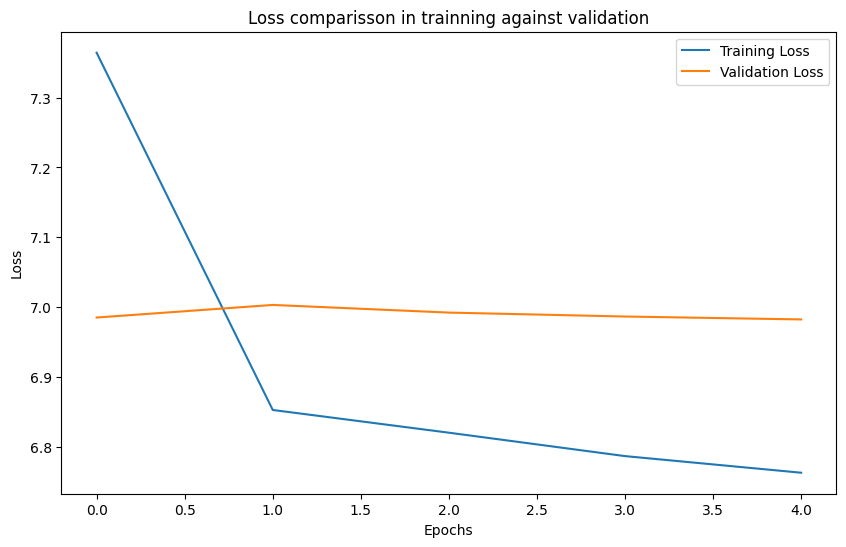

In [17]:
plot_history(history)

# 3. Text Generation (Complete or Incomplete)

Write a method called `generate_text` that uses the trained model to generate new text. The method should take the following parameters:

*   `model`: The trained RNN model.
*   `tokenizer`: The tokenizer used to pre-process the text data.
*   `seed_text`: The seed text the model will use to generate new text.
*   `max_sequence_len`: The maximum length of the sequence used to generate new text.

The method should return the generated text.

An overview of the text generation process you should follow:

1. Tokenize the seed text using the tokenizer we built before.
2. Pad the sequences to the same length as the training sequences - you can use the `pad_sequences` method from the `keras.preprocessing.sequence` module, which is documented [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences).
3. Use the model to predict the next token in the sequence. Remember that the model will output a probability distribution over the vocabulary, so you'll need to use `np.argmax` to find the token with the highest probability.
4. Add the predicted token to the sequence and remove the first token.
5. Repeat steps 3-4 until you have generated the desired number of tokens.
6. Convert the generated token IDs back to words and return the combined result as a single string.

This is a challenging task, so don't hesitate to ask for help if you need it. It's okay if the generated text doesn't make much sense yet - we'll work on improving the model next.
As a bonus, you can make your method generate "gpt-style" by having it print out each word as it's generated, so you can see the text being generated in real time.

In [18]:
from keras.preprocessing.sequence import pad_sequences

def get_predicted_word(model, sequence):
    """
    Get the predicted word from the model.
    This helper function uses a concept we haven't covered in class yet: temperature.
    In essence, a little bit of randomness in what word we predict can make the text more interesting.
    """

    # Use the model to predict the next token in the sequence
    yhat = model.predict(sequence, verbose=0)

    # Get the index of the predicted word, according to the probabilities
    yhat = np.random.choice(range(VOCAB_SIZE), p=yhat.ravel())

    return yhat

def generate_text(model, tokenizer, seed_text, max_sequence_len):
    """
    Generate new text using the trained model.
    You can use the `get_predicted_word` helper function to help you with this.
    """
    # Initialize the generated text with the seed text
    generated_text = seed_text

    # Generate text for the desired number of tokens
    for _ in range(max_sequence_len):
        # Tokenize and pad the current sequence
        tokenized_sequence = tokenizer.texts_to_sequences([generated_text])[0]
        tokenized_sequence = pad_sequences([tokenized_sequence], maxlen=max_sequence_len, padding='pre')

        # Predict the next word
        predicted_token_id = get_predicted_word(model, tokenized_sequence)

        # Get the word corresponding to the predicted token ID
        predicted_word = tokenizer.index_word.get(predicted_token_id, '')

        # Stop generation if no word is predicted
        if predicted_word == '':
            break

        # Append the predicted word to the generated text
        generated_text += ' ' + predicted_word

    return generated_text
    return None


In [19]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet and fashion what or good up thoughts hand his favourite herself his sure me with re was charge conj laying'

It's likely that the text generated by your model doesn't make much sense yet. This is because the model hasn't been trained for very long, and the training dataset is relatively small.

# 4. Model Refinement (Complete or Incomplete)

In this last section, you'll work on improving your model. There are many ways to do this, but here are a few ideas to get you started:

* Use pre-trained embeddings: the code below will help you to load pre-trained embeddings through Keras.
* Experiment with different model architectures, including the number of layers, the number of units in each layer, and the use of dropout layers.
* Train your model for longer. You can also experiment with different batch sizes.

Implement and test out at least one of these ideas. If you have other ideas for improving the model, feel free to try them out as well.

In [20]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2024-12-07 17:32:22--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  4.99MB/s    in 2m 38s  

2024-12-07 17:35:01 (5.19 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
# Load the pre-trained embeddings
embeddings_index = {}
try:
    with open('glove.6B.100d.txt', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print(f'Found {len(embeddings_index)} word vectors.')
except FileNotFoundError:
    print("'glove.6B.100d.txt' File not found. Please make sure you have ran the previous cell.")

Found 400000 word vectors.


In [22]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    # Create an embedding matrix
    embedding_matrix = np.zeros((VOCAB_SIZE, 100))
    for word, i in tokenizer.word_index.items():
        if i < VOCAB_SIZE:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

In [23]:
# Check if VOCAB_SIZE is set
if VOCAB_SIZE is None:
    print("You need to complete the previous parts of your assignment in order for this to work.")
else:
    embedding_layer = Embedding(
        VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=SEQ_LENGTH, trainable=False
    )

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [24]:
# Define a new model and train it
from keras.layers import Dropout, Bidirectional
from keras.regularizers import l2

L2_RATE=1e-4

model = Sequential([
    # Embedding layer with pre-trained weights and no training on embeddings
    embedding_layer,

    # LSTM layer - Dropped because it did not help too much to the model
    # LSTM(units=192, return_sequences=True,kernel_regularizer=l2(L2_RATE)),
    # Dropout(0.3),

    # Intermediate LSTM layer
    Bidirectional(LSTM(units=128, return_sequences=True,kernel_regularizer=l2(L2_RATE))),
    Dropout(0.2),

    # Final LSTM layer
    Bidirectional(LSTM(units=64, return_sequences=False,kernel_regularizer=l2(L2_RATE))),
    Dropout(0.4), # Higher dropout to reach the final layer

    # Dense output layer
    Dense(VOCAB_SIZE, activation='softmax')
])

# Compile the model
model.compile(
    # Using gradient clipping to prevent exploding gradients
    optimizer=Adam(learning_rate=L2_RATE, clipnorm=1.0), # Using the same LR as L2 rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │         721,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 721,200 (2.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 721,200 (2.75 MB)

In [25]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

EPOCHS = 100  # Training for more epochs to leverage pre-trained embeddings

# Try a learning rate schedule that reduces the learning rate when it plateaus:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# if after 3 cycles of LR reduction the thing does not improve shut it down
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=128,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.0259 - loss: 8.0962 - val_accuracy: 0.0406 - val_loss: 7.0016 - learning_rate: 1.0000e-04
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0377 - loss: 6.9141 - val_accuracy: 0.0406 - val_loss: 7.0087 - learning_rate: 1.0000e-04
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0406 - loss: 6.8693 - val_accuracy: 0.0406 - val_loss: 7.0069 - learning_rate: 1.0000e-04
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - accuracy: 0.0406 - loss: 6.8465 - val_accuracy: 0.0408 - val_loss: 6.9833 - learning_rate: 1.0000e-04
Epoch 5/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 24s 33ms/step - accuracy: 0.0399 - loss: 6.8075 - val_accuracy: 0.0436 - val_loss: 6.9612 - learning_rate: 1.0000e-04
Epoch 6/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - accuracy: 0.0421 - loss: 6.7612 - val_accuracy: 0.0459 - val_loss: 6.9316 - learning_rate: 1.0000e-04
Epoch 7/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 19s 2

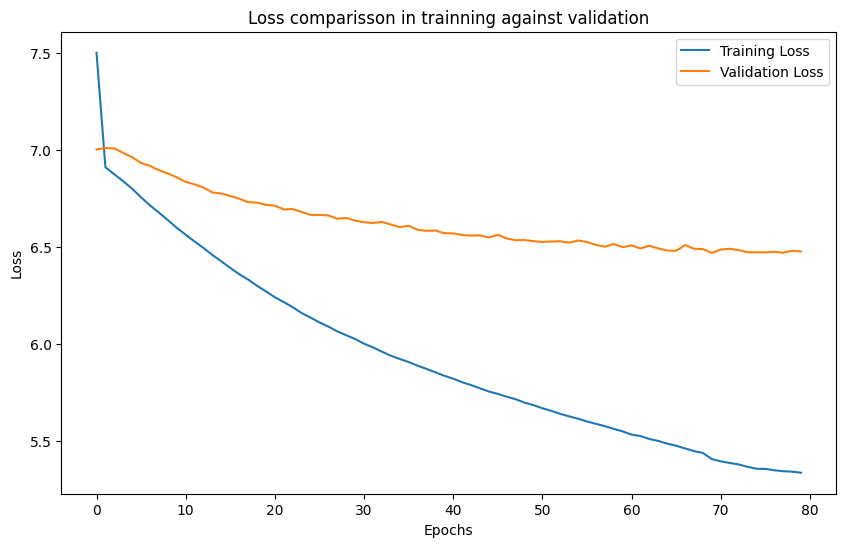

In [26]:
plot_history(history)

In [27]:
# run the same test as before
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

"hamlet and flout pope 133 information collier 131 teach above pope forth book v may'st lies om ap 138 pockets with"

## Criteria

|Criteria|Complete|Incomplete|
|----|----|----|
|Task 1|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 2|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 3|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|
|Task 4|The task has been completed successfully and there are no errors.|The task is still incomplete and there is at least one error.|

## Submission Information

🚨**Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)**🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/deep_learning/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.